In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader_02 import PuljaDataLoader
from models._20220726_10 import UserModel
from models.utils_02 import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 1000

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_c3, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220726_10"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (C): Embedding(78, 20)
  (D): Embedding(7, 1)
  (R): Embedding(2, 20)
  (gru): GRU(60, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=78, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [4]:
aucs_list = []
max_aucs = []
fin_aucs = []

dir_list = ["01"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_20220726_10", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)
    fin_auc = aucs[-1]

    aucs_list.append(aucs)
    max_aucs.append(max_auc)
    fin_aucs.append(fin_auc)

In [5]:
print("max_aucs: {}".format(max_aucs))
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))
print("max_auc_dir: {}".format(dir_list[np.argmax(max_aucs)]))

max_aucs: [0.7378728684130732]
max_auc_mean: 0.7378728684130732, max_auc_std: 0.0
max_auc_dir: 01


In [6]:
print("max_fin_aucs: {}".format(fin_aucs))
print("max_fin_auc_mean: {}, max_auc_std: {}".format(np.mean(fin_aucs), np.std(fin_aucs)))
print("max_fin_auc_dir: {}".format(dir_list[np.argmax(fin_aucs)]))

max_fin_aucs: [0.7368997775506337]
max_fin_auc_mean: 0.7368997775506337, max_auc_std: 0.0
max_fin_auc_dir: 01


In [7]:
test_dataset[3]

(array([29, 29, 29, ..., 76, 76, 76]),
 array([2, 2, 3, ..., 4, 4, 4]),
 array([1, 1, 0, ..., 0, 0, 0]))

In [8]:
# 3, 6
c3_seq, d_seq, r_seq = test_dataset[3]

view_from = 0
view_to = 1000

seq_len = view_to - view_from

c3_seq = [c3_seq[view_from:view_to]]
d_seq = [d_seq[view_from:view_to]]
r_seq = [r_seq[view_from:view_to]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 6

# c_seq = np.array([[0] * 100])
# d_seq = np.array([[6] * 30 + [3] * 30 + [0] * 40])
# r_seq = np.ones_like(r_seq)

# c1_seq, c2_seq, c4_seq, d_seq, r_seq: [batch_size, seq_len]

alpha_seq, h_seq, C3_seq = model(
    LongTensor(c3_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)

# C3_seq: [batch_size, seq_len, num_c4]

# beta3_seq: [batch_size, seq_len]
beta3_seq = torch.gather(C3_seq, dim=-1, index=LongTensor(c3_seq).unsqueeze(-1)).reshape([1, seq_len])

# gamma_seq: [seq_len]
gamma_seq = model.D(LongTensor(d_seq)).squeeze()

###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

sigmoid_beta_seq = torch.sigmoid(beta3_seq).detach().cpu().numpy()[0]

sigmoid_beta_gamma_seq = torch.sigmoid(beta3_seq - gamma_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ3_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()
CQ3_seq = torch.sigmoid(CQ3_seq).detach().cpu().numpy()[0]

# C3_seq = C3_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

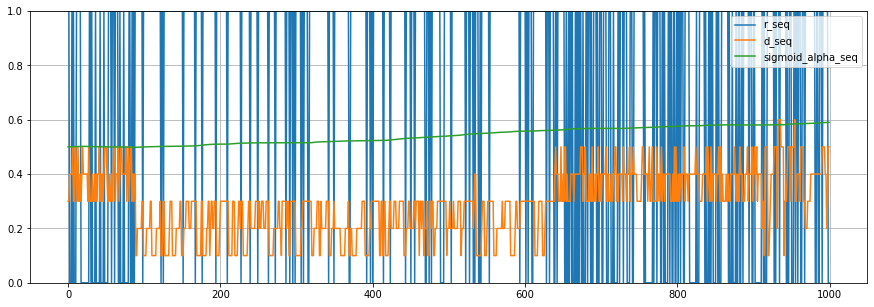

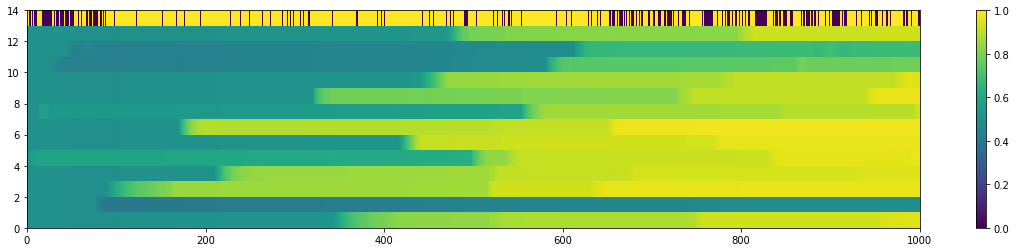

In [9]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
# plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_beta_seq")
# plt.plot(sigmoid_alpha_beta4_seq, label="sigmoid_beta_gamma_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure(figsize=[20, len(np.unique(c3_seq)) // 3], facecolor="white")
temp = np.concatenate([CQ3_seq[:, np.unique(c3_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

In [10]:
CQ3_seq[0][np.unique(c3_seq)]

array([0.5001979, 0.5001979, 0.5001979, 0.5001979, 0.515629 , 0.5001979,
       0.5001979, 0.5001979, 0.5001979, 0.5001979, 0.5001979, 0.5001979,
       0.5001979], dtype=float32)

In [11]:
CQ3_seq[-1][np.unique(c3_seq)]

array([0.94974357, 0.4899074 , 0.9684552 , 0.9473131 , 0.9713902 ,
       0.96684074, 0.9775909 , 0.92602605, 0.9652758 , 0.9488201 ,
       0.7805096 , 0.68220496, 0.927532  ], dtype=float32)

In [12]:
np.unique(c3_seq), c3_seq

(array([ 8, 17, 26, 27, 29, 40, 42, 50, 55, 71, 73, 75, 76]),
 [array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 50, 50, 50, 50, 50,
         50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 73, 73, 73, 73, 73, 73,
         73, 73, 73, 73, 73, 73, 73, 73, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 17, 17, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 17, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
         42, 4

In [13]:
dataset.c3_list[np.unique(c3_seq)]

array(['01 명제와 조건', '01 유리식', '01 집합의 뜻과 표현', '01 집합의 연산', '01 함수',
       '02 명제의 역, 대우', '02 부분집합', '02 여러 가지 함수', '02 원소의 개수',
       '03 충분조건과 필요조건', '03 합성함수', '04 역함수', '04 절대부등식'], dtype=object)

In [14]:
dataset.c3_list[np.unique(c3_seq)[np.argmin(CQ3_seq[-1][np.unique(c3_seq)])]]

'01 유리식'

In [15]:
dataset.c32c4_list[dataset.c3_list[np.unique(c3_seq)[np.argmin(CQ3_seq[-1][np.unique(c3_seq)])]]]

['[1] 유리식의 사칙연산',
 '[2] 유리식과 항등식',
 '[3] (분자의 차수)≥(분모의 차수)인 유리식',
 '[4] 부분분수로의 변형',
 '[5] 번분수식의 계산',
 '[6] 유리식의 값 구하기-x^n±1/x^n의 꼴',
 '[7] 유리식의 값 구하기-a+b+c=0이 주어질 때',
 '[8] 유리식의 값 구하기-비례식이 주어질 때',
 '[9] 유리식의 값 구하기-방정식이 주어질 때']

In [16]:
d_seq

[array([2, 2, 3, 3, 3, 3, 4, 2, 2, 4, 4, 3, 2, 4, 2, 2, 3, 2, 3, 4, 3, 3,
        3, 3, 3, 3, 2, 4, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 4, 2, 3,
        2, 3, 2, 3, 4, 4, 4, 3, 2, 2, 3, 2, 2, 3, 2, 3, 4, 4, 2, 3, 3, 3,
        4, 2, 3, 4, 4, 3, 3, 3, 3, 3, 4, 2, 3, 4, 2, 3, 4, 4, 2, 3, 2, 3,
        3, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
        0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1,
        1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2,
        2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 2, 0, 0, 0,
        0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0,
        0, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 

In [17]:
model.D.weight

Parameter containing:
tensor([[-0.7802],
        [-0.4747],
        [-0.0429],
        [ 0.4836],
        [ 0.4277],
        [ 0.9816],
        [ 2.4444]], requires_grad=True)

In [18]:
h_seq.shape

torch.Size([1, 1000, 20])

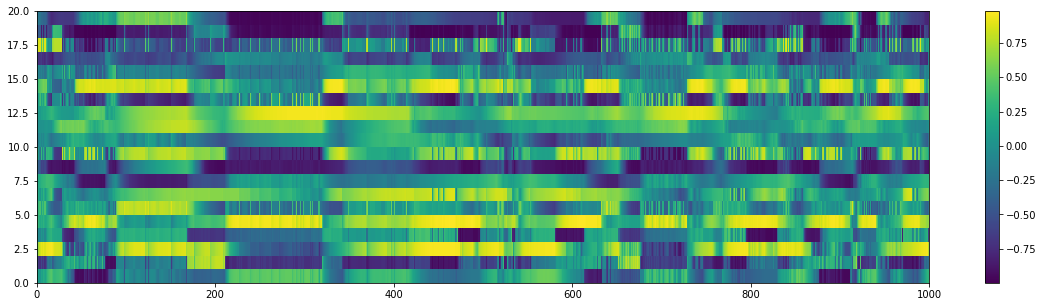

In [19]:
plt.figure(figsize=[20, 5], facecolor="white")
plt.pcolormesh(h_seq[0].detach().cpu().numpy().T)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [20]:
dataset.c22c3_list

{'01 다항식의 연산': ['01 다항식의 연산', '02 다항식의 곱셈공식', '03 다항식의 나눗셈'],
 '01 삼각비': ['소단원'],
 '01 제곱근과 실수': ['소단원'],
 '01 지수': ['01 거듭제곱과 거듭제곱근', '02 지수의 확장'],
 '01 집합의 뜻과 표현': ['01 집합의 뜻과 표현', '02 부분집합'],
 '01 함수의 극한': ['01 함수의 극한', '02 함수의 극한에 대한 성질', '03 함수의 극한의 응용'],
 '02 로그': ['01 로그의 뜻과 성질', '02 상용로그'],
 '02 삼각형의 외심과 내심': ['소단원'],
 '02 집합의 연산': ['01 집합의 연산', '02 원소의 개수'],
 '02 함수의 연속': ['01 함수의 연속', '02 연속함수의 성질'],
 '02 항등식과 나머지정리': ['01 항등식', '02 나머지정리와 인수정리'],
 '03 명제': ['01 명제와 조건', '02 명제의 역, 대우', '03 충분조건과 필요조건', '04 절대부등식'],
 '03 미분계수와 도함수': ['01 미분계수', '02 도함수'],
 '03 원과 직선': ['소단원'],
 '03 인수분해': ['01 인수분해'],
 '03 지수함수': ['01 지수함수의 뜻과 그래프', '02 지수함수의 최대 · 최소', '03 지수함수의 활용'],
 '04 도함수의 활용(1)': ['01 접선의 방정식', '02 평균값 정리'],
 '04 로그함수': ['01 로그함수의 뜻과 그래프', '02 로그함수의 최대 · 최소', '03 로그함수의 활용'],
 '04 복소수': ['01 복소수의 성질과 연산', '02 i의 거듭제곱, 음수의 제곱근'],
 '04 원주각': ['소단원'],
 '04 함수': ['01 함수', '02 여러 가지 함수', '03 합성함수', '04 역함수'],
 '05 대푯값과 산포도': ['소단원'],
 '05 도함수의 활용(2)': ['01 함수의 증가와 감소', '02 함수

In [21]:
c2 = "01 집합의 뜻과 표현"

CQ2_seq = []
CQ2_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()[:, [dataset.c32idx[c3] for c3 in dataset.c22c3_list[c2]]].mean(-1, keepdims=True)
CQ2_seq = torch.sigmoid(CQ2_seq).detach().cpu().numpy()[0]

CQ2_seq[0], CQ2_seq[-1]

(array([0.5001979], dtype=float32), array([0.97340196], dtype=float32))

In [22]:
c2 = "04 함수"

CQ2_seq = []
CQ2_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()[:, [dataset.c32idx[c3] for c3 in dataset.c22c3_list[c2]]].mean(-1, keepdims=True)
CQ2_seq = torch.sigmoid(CQ2_seq).detach().cpu().numpy()[0]

CQ2_seq[0], CQ2_seq[-1]

(array([0.5040569], dtype=float32), array([0.8830032], dtype=float32))

In [23]:
c2 = "05 유리함수"

CQ2_seq = []
CQ2_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()[:, [dataset.c32idx[c3] for c3 in dataset.c22c3_list[c2]]].mean(-1, keepdims=True)
CQ2_seq = torch.sigmoid(CQ2_seq).detach().cpu().numpy()[0]

CQ2_seq[0], CQ2_seq[-1]

(array([0.5001979], dtype=float32), array([0.54052263], dtype=float32))

In [24]:
dataset.num_c3

78

In [25]:
C3_seq.shape

torch.Size([1, 1000, 78])

In [26]:
model.eval()
alpha_seq, h_seq, C3_seq = model(
    LongTensor(c3_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)

model.eval()
alpha_seq_0, h_seq_0, C3_seq_0 = model(
    LongTensor(c3_seq)[:, :50],
    LongTensor(d_seq)[:, :50],
    LongTensor(r_seq)[:, :50],
)

alpha_seq_1, h_seq_1, C3_seq_1 = model(
    LongTensor(c3_seq)[:, 50:],
    LongTensor(d_seq)[:, 50:],
    LongTensor(r_seq)[:, 50:],
    h_seq_0[:, -1, :],
    C3_seq_0[:, -1, :],
)

alpha_seq_2 = torch.cat([alpha_seq_0, alpha_seq_1], dim=-1)
h_seq_2 = torch.cat([h_seq_0, h_seq_1], dim=1)
C3_seq_2 = torch.cat([C3_seq_0, C3_seq_1], dim=1)

In [27]:
(alpha_seq - alpha_seq_2).max(), (h_seq - h_seq_2).max(), (C3_seq - C3_seq_2).max()

(tensor(5.9605e-08, grad_fn=<MaxBackward1>),
 tensor(8.9407e-08, grad_fn=<MaxBackward1>),
 tensor(4.7684e-07, grad_fn=<MaxBackward1>))

In [28]:
print(np.random.normal(size=[20]))

[ 0.13465622 -2.03276335  0.2855119   1.36961897  1.58717888 -1.42080772
 -0.54092848 -0.13990814 -0.8609466  -1.44656196  1.44764132 -0.24576321
  1.04060175  0.06953556  0.84449684  0.52186134 -0.1288043   0.47195709
 -0.89829427 -1.2647429 ]


In [29]:
np.random.normal(size=[dataset.num_c3])

array([-1.48848602, -0.42354313, -0.19016198,  0.91611364, -0.42667445,
       -1.39020636, -0.9165318 ,  0.15543322,  1.36518534,  0.44658918,
        0.05375333,  0.16412725,  0.20155569,  0.14169846,  0.62089018,
        0.28179818,  1.30347739, -0.89744407, -1.29720141, -0.82857587,
       -0.57586571,  1.06235028, -0.17742888, -0.90528273,  1.30471044,
       -0.45689504, -2.457913  , -2.39394392, -0.78904943,  0.54624006,
        0.70141   , -1.4004716 ,  1.52853467,  0.48998392, -0.52507543,
        0.62814961, -0.25637207, -0.11931852,  1.01283746,  0.50607864,
       -0.10114033,  0.33860297,  1.10173774, -1.08967321, -0.17095612,
       -0.72312177,  0.25496203, -0.39384669,  1.77547693, -1.17976439,
        0.96172693, -0.38026456, -0.1353133 ,  0.59213246,  0.52868513,
        0.13744396, -0.02815304,  0.52906935, -1.34741152,  1.47714228,
       -0.75886219,  1.02099321, -0.0709053 ,  0.39810522, -0.06899084,
        0.39681729, -1.12369972, -0.68457797, -1.22325215, -1.48